# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(110)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that the moneyness
$$ K/S0 \in [0.75, 1.35] $$ have been selected.

In [73]:
df_put = pd.read_csv('../../data/AAPL/OPT16_AAPL_PUTS_75_135.csv')
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put)

NUM OF PUT OPTS: 15
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  P_BID  P_ASK  STRIKE     P_IV   
0   2016-01-20            96.79  2017-01-20   4.40   4.49    75.0  0.36617  \
1   2016-01-20            96.79  2017-01-20   5.80   5.95    80.0  0.35755   
2   2016-01-20            96.79  2017-01-20   7.50   7.65    85.0  0.34912   
3   2016-01-20            96.79  2017-01-20   8.44   8.60    87.5  0.34493   
4   2016-01-20            96.79  2017-01-20   9.55   9.65    90.0  0.34241   
5   2016-01-20            96.79  2017-01-20  10.70  10.81    92.5  0.33994   
6   2016-01-20            96.79  2017-01-20  11.90  12.04    95.0  0.33684   
7   2016-01-20            96.79  2017-01-20  13.15  13.36    97.5  0.33399   
8   2016-01-20            96.79  2017-01-20  14.51  14.76   100.0  0.33138   
9   2016-01-20            96.79  2017-01-20  17.50  17.71   105.0  0.32641   
10  2016-01-20            96.79  2017-01-20  20.75  20.99   110.0  0.32280   
11  2016-01-20            96.79  2017-01-20 

The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [74]:
puts = df_put.sample(frac=1, replace=False).sort_index().reset_index(drop=True)

puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']
put_prices = puts['P_Midpoint']


q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'


The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.P

In [75]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

Same for put prices.

In [76]:
put_th_prices = pd.DataFrame(columns=['Strike','Price', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes
put_th_prices['Price'] = put_prices

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 2:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    Strike   Price BlackScholes     Merton        Kou VarianceGamma
0     75.0   4.445     2.288441   0.500824   0.857554      0.145503
1     80.0   5.875     3.477505   0.971757   1.348824      0.488348
2     85.0   7.575     5.005186   1.750304   2.131249      1.283526
3     87.5   8.520     5.900609   2.288366   2.668826      1.907301
4     90.0   9.600     6.884442   2.942377   3.322706      2.695313
5     92.5  10.755     7.956189   3.722891   4.104448      3.647683
6     95.0  11.970     9.114635   4.638021   5.022612      4.758812
7     97.5  13.255     10.35793    5.69293   6.082238      6.019299
8    100.0  14.635    11.683685   6.889561   7.284661      7.417527
9    105.0  17.605     14.57084   9.699762  10.105769     10.576544
10   110.0  20.870     17.74953  13.024429  13.433526     14.136094
11   115.0  24.445    21.189961  16.786556  17.185123     18.007109
12   120.0  28.195    24.861268  20.894875  21.268068     22.116187
13   125.0  32.2

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [77]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **call** and **put** options market prices.

Implied volatilities of market prices (puts):
S0 = 96.79
K = 75.0, IV = 0.3648
K = 80.0, IV = 0.3565
K = 85.0, IV = 0.3484
K = 87.5, IV = 0.3441
K = 90.0, IV = 0.3416
K = 92.5, IV = 0.3392


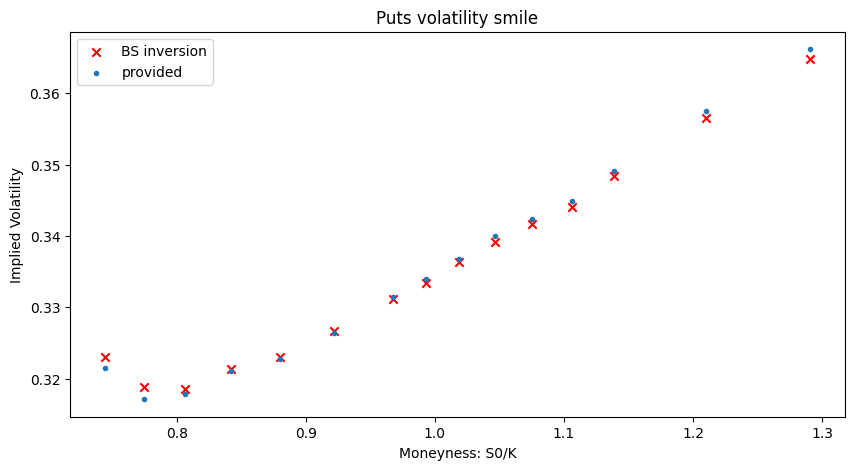

In [78]:
IV_market_p = []
for i in range(len(put_prices)):
    IV_market_p.append(implied_volatility(put_prices[i], S=S0, strike=put_strikes[i], t = T, rate=0.02, q = 0.027, type_o='put', method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for a,b in zip(put_strikes.head(6), IV_market_p[:6]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/put_strikes)
IV_filtered = [iv for iv in IV_market_p if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
puts_filtered = [p_iv for iv, p_iv in zip(IV_market_p, puts['P_IV']) if iv != -1 ]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x_filtered, IV_filtered, marker='x', label='BS inversion', color='red')
ax1.scatter(x_filtered, puts_filtered, marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Puts volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [79]:
put_spreads = puts['P_Spread']
p_weights = 1 / put_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [80]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_puts(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes_puts, put_strikes, put_prices, p0 = x0, bounds=bounds, sigma=p_weights)
sigw_p = round(res1_puts[0][0],4)

In [81]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum( p_weights* (BS.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=1)
opt_sigma_p = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 4.4478e+07, final cost 5.0860e+02, first-order optimality 1.33e+00.


In [82]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.3948 	 39.48%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.38217918075217366 	 38.22%


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [ ]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [ ]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_put(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [ ]:
x0 = [0.1,  0.5, 0.3,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum( p_weights*(M.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=2)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

In [83]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.2981 	 29.81%
> Calibrated Jump intensity [λ] =  0.05
> Calibrated Jump Mean =  -1.79
> Calibrated Jump St. dev.  =  2.0
ELAPSED TIME: 27.628026485443115 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.0983 	 9.83%
> Calibrated Jump intensity [λ] =  2.57
> Calibrated Jump Mean =  0.215
> Calibrated Jump St. dev.  =  0.056
TIME ELAPSED:  208.89 sec


In [84]:
print(mert_params1)
print(mert_params2)

[0.2981, 0.0502, -1.7882, 2.0]
[0.0983, 2.5653, 0.2151, 0.0562]


### Kou Jump Diffusion


In [85]:
x0 = [0.3, 0.8, 0.5, 5, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0.5, 0.5], [0.5, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [ ]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_put(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [ ]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(p_weights*(KOU.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2)
end2=time.time()

In [86]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [87]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [88]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3414 	 34.14%
> Calibrated Jump intensity [λ] =  0.77
> Calibrated Upward Jump probability [p] = 0.39, [q] = 0.61
> Calibrated Rate of Exp. 1  [η_1] =  5.43
> Calibrated Rate of Exp. 2  [η_2] =  9.93
TIME ELAPSED:  208.89 sec


In [89]:
#print(kou_params1)
print(kou_params2)

[0.3414, 0.7704, 0.387, 5.4276, 9.9265]


### Variance Gamma


In [90]:
x0 = [0.2, -0.3, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [3, 5, 10] )

##### Method 1. CURVE FIT (Bounds)

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise='put')
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_put(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [ ]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(p_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

In [91]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.4335, 	 43.35%
> Calibrated mean rate gamma process [θ] =  0.0852
> Calibrated variance rate gamma process [v]=  1.2185
TIME ELAPSED:  27.63 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3938, 	 39.38%
> Calibrated mean rate gamma process [θ] =  0.0371
> Calibrated variance rate gamma process [v]=  0.2901
TIME ELAPSED:  208.89 sec


In [92]:
print(vg_params1)
print(vg_params2)

[0.4335, 0.0852, 1.2185]
[0.3938, 0.0371, 0.2901]


### Reprice of options using calibrated parameters
The following code snippet aims to find the best parameters for each model, minimizing the difference between the monte carlo prices and the market prices of **call** and **put** options.

In [93]:
days = 252
paths = 5000

put_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{put_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0     75.0     4.40    4.445     4.49
1     80.0     5.80    5.875     5.95
2     85.0     7.50    7.575     7.65
3     87.5     8.44    8.520     8.60
4     90.0     9.55    9.600     9.65
5     92.5    10.70   10.755    10.81
6     95.0    11.90   11.970    12.04
7     97.5    13.15   13.255    13.36
8    100.0    14.51   14.635    14.76
9    105.0    17.50   17.605    17.71
10   110.0    20.75   20.870    20.99
11   115.0    24.29   24.445    24.60
12   120.0    28.04   28.195    28.35
13   125.0    32.06   32.230    32.40
14   130.0    36.35   36.520    36.69


#### Merton Jump Diffusion model

In [94]:
#mert_params2 = [0.1267, 0.951, -0.1182, 0.2691]
sigma, lambd, meanJ, stdJ = mert_params2
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(put_calib_prices))
merton_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_put(put_strikes[index])

put_calib_prices['MERTON MC'] = merton_mc_prices
put_calib_prices['MERTON CF'] = merton_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF
0     75.0     4.40    4.445     4.49   3.706689   3.639028
1     80.0     5.80    5.875     5.95   5.391742   5.317692
2     85.0     7.50    7.575     7.65   7.405845   7.327747
3     87.5     8.44    8.520     8.60   8.528875   8.452407
4     90.0     9.55    9.600     9.65   9.730144   9.653123
5     92.5    10.70   10.755    10.81  11.007722  10.926520
6     95.0    11.90   11.970    12.04  12.346329  12.269021
7     97.5    13.15   13.255    13.36  13.746186  13.677046
8    100.0    14.51   14.635    14.76  15.214746  15.147135
9    105.0    17.50   17.605    17.71  18.334844  18.260404
10   110.0    20.75   20.870    20.99  21.669258  21.583834
11   115.0    24.29   24.445    24.60  25.197945  25.093831
12   120.0    28.04   28.195    28.35  28.890945  28.768161
13   125.0    32.06   32.230    32.40  32.734848  32.586485
14   130.0    36.35   36.520    36.69  36.729618  36.530749


In [95]:
#kou_params2 = [0.1278, 0.948, 0.3549, 5.7153, 4.232]
sigma, lambd, p, eta1, eta2 = kou_params2
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(put_calib_prices))
kou_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_put(put_strikes[index])

put_calib_prices['KOU MC'] = kou_mc_prices
put_calib_prices['KOU CF'] = kou_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC   
0     75.0     4.40    4.445     4.49   3.706689   3.639028   4.013399  \
1     80.0     5.80    5.875     5.95   5.391742   5.317692   5.562094   
2     85.0     7.50    7.575     7.65   7.405845   7.327747   7.414576   
3     87.5     8.44    8.520     8.60   8.528875   8.452407   8.448810   
4     90.0     9.55    9.600     9.65   9.730144   9.653123   9.552869   
5     92.5    10.70   10.755    10.81  11.007722  10.926520  10.731989   
6     95.0    11.90   11.970    12.04  12.346329  12.269021  11.984668   
7     97.5    13.15   13.255    13.36  13.746186  13.677046  13.300633   
8    100.0    14.51   14.635    14.76  15.214746  15.147135  14.683537   
9    105.0    17.50   17.605    17.71  18.334844  18.260404  17.661451   
10   110.0    20.75   20.870    20.99  21.669258  21.583834  20.881843   
11   115.0    24.29   24.445    24.60  25.197945  25.093831  24.320716   
12   120.0    28.04   28.195    28.35 

In [96]:
# vg_params2 = [0.2442, 0.1983, 0.9451]
sigma, theta, nu = vg_params2
VGCAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath1(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(put_calib_prices))
vg_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_put(put_strikes[index])

put_calib_prices['VG MC'] = vg_mc_prices
put_calib_prices['VG CF'] = vg_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC   
0     75.0     4.40    4.445     4.49   3.706689   3.639028   4.013399  \
1     80.0     5.80    5.875     5.95   5.391742   5.317692   5.562094   
2     85.0     7.50    7.575     7.65   7.405845   7.327747   7.414576   
3     87.5     8.44    8.520     8.60   8.528875   8.452407   8.448810   
4     90.0     9.55    9.600     9.65   9.730144   9.653123   9.552869   
5     92.5    10.70   10.755    10.81  11.007722  10.926520  10.731989   
6     95.0    11.90   11.970    12.04  12.346329  12.269021  11.984668   
7     97.5    13.15   13.255    13.36  13.746186  13.677046  13.300633   
8    100.0    14.51   14.635    14.76  15.214746  15.147135  14.683537   
9    105.0    17.50   17.605    17.71  18.334844  18.260404  17.661451   
10   110.0    20.75   20.870    20.99  21.669258  21.583834  20.881843   
11   115.0    24.29   24.445    24.60  25.197945  25.093831  24.320716   
12   120.0    28.04   28.195    28.35 

### Visualize calibration results
#### Closed Formulas Option pricing

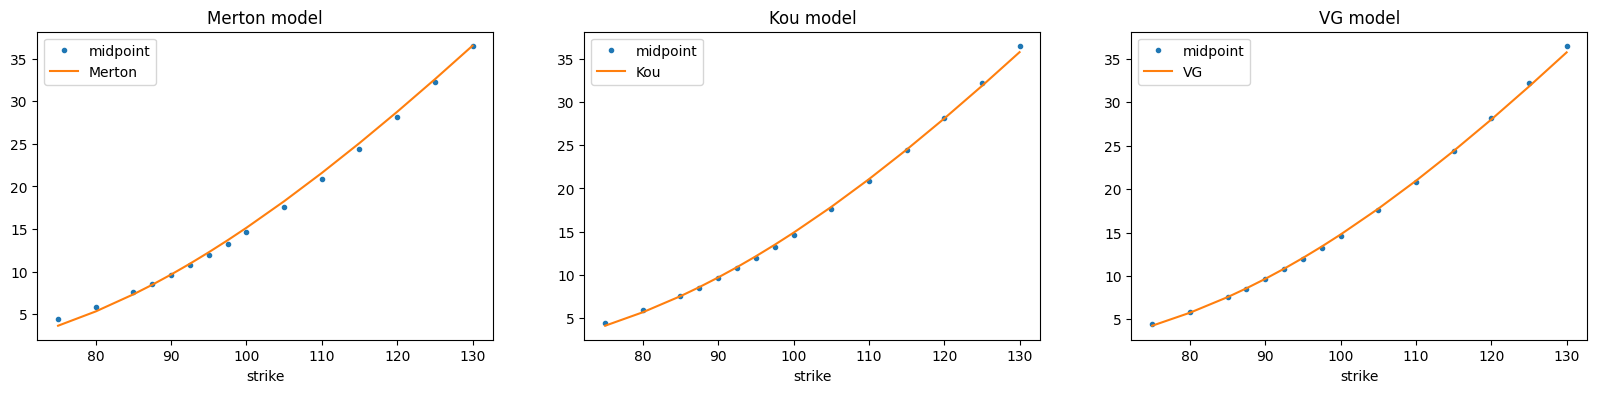

In [97]:
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_cf_prices, label="Merton")
ax2.plot(put_strikes, kou_cf_prices, label="Kou")
ax3.plot(put_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


#### Monte Carlo option pricing

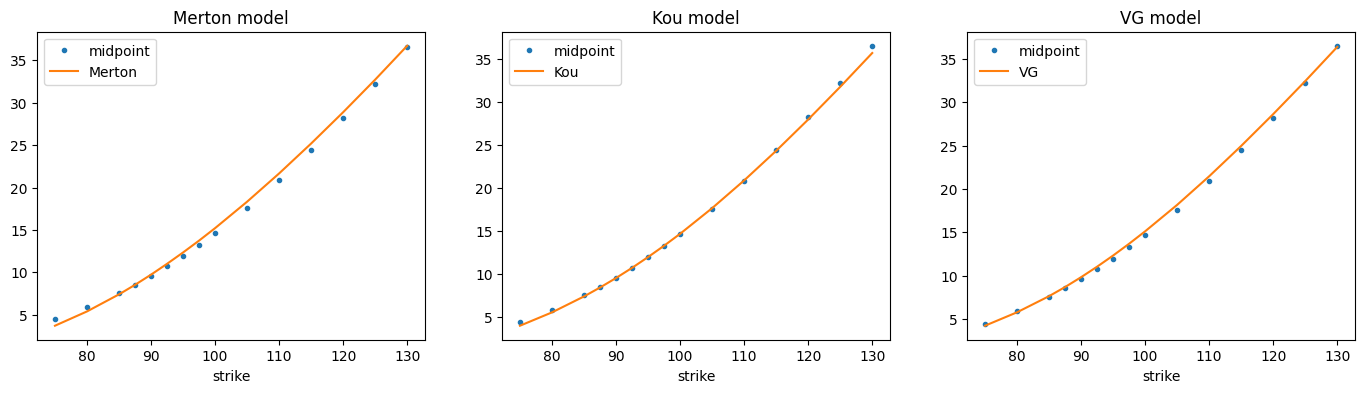

In [98]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_mc_prices, label="Merton")
ax2.plot(put_strikes, kou_mc_prices, label="Kou")
ax3.plot(put_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()